In [1]:
# importing required packages
import pandas as pd
import numpy as np

#to time functions
from tqdm import tqdm

#For datetime format
from datetime import datetime as dt

#To plot
import matplotlib.pyplot as plt

import re
import time

#importing libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import binarize

# 1. Finding Similar Costumers

## Preprocessing

In [2]:
data = pd.read_csv("bank_transactions.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


Let's visualize our data

In [4]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


The table contains information on transactions made by customers. Each row represents a single transaction and includes details such as customer ID, date of birth, location, account balance, and the date, time, and amount of the transaction in Indian rupees. The customer ID is a unique identifier likely used by the company to keep track of customers and their transactions. Date of birth is used to identify and verify the age of the customer. Location is used to identify the geographic region where the transaction took place. Account balance is the amount of money the customer had available in their account at the time of the transaction. The date and time of the transaction are used to track and organize transactions, while the transaction amount is used to calculate account balances and monitor the company's financial performance.

Check if we have na values and drop them if needed.

In [5]:
data.dropna(inplace=True)

### Convert the columns rappresenting time into datetime format

In [6]:
#Convert the transaction Time into hour
data.TransactionTime = data.TransactionTime.apply(lambda x: dt.strptime(str(x).zfill(6), '%H%M%S').hour)

#Convert CustomerDOB to datetime format
data.CustomerDOB = pd.to_datetime(data.CustomerDOB)

#Convert TransactionDate to datetime format
data.TransactionDate = pd.to_datetime(data.TransactionDate)

### Let's deal with the offset people born after 2000, and the people born before 1800

In [7]:
#Offset the people born after 2000
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

#
data.drop(data[data.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

In [8]:
#Convert to Month and Day format
data.TransactionDate = data.TransactionDate.apply(lambda x: x.to_period('M'))

### I don't need all the columns in this dataFrame

In [9]:
def cleaning(text):
    text = re.sub(r'[^\w\s]','',text)
    tokens = text.lower()
    tokens = tokens.split()
    return tokens

In [186]:
#Remove Transaction ID
data2 = data.iloc[:, 1:]

#Drop the gender since we might have multiple genere for one CustomerID
data2.drop(['CustGender'], axis = 1, inplace=True)

### Place the numeric variable in a range of values

In [187]:
#Rename the colum so that i can use dot notation
data2.rename(columns = {"TransactionAmount (INR)": "TransactionAmount_INR"}, inplace = True)

Create the range for CustAccountBalance

In [188]:
range1 = np.quantile(data2.CustAccountBalance, np.arange(0,1,0.1))

range1 = range1.tolist()

range1 = list(map(int, range1))

range1.append(data2.CustAccountBalance.max())

range1 = list(map(int, range1))

range1.remove(0)

Apply this range to the columns

In [189]:
bins = pd.qcut(data2.CustAccountBalance, 10, retbins = True, duplicates = 'drop',labels=False)

data2.CustAccountBalance = bins[0]

data2.CustAccountBalance = data2.CustAccountBalance.apply(lambda x :  range1[x])

Now do the same process for the Transaction Amount Column

In [190]:
range2 = np.quantile(data2.TransactionAmount_INR, np.arange(0,1,0.1))

range2 = list(map(int, range2))

range2.remove(0)

range2.append(data2.TransactionAmount_INR.max())

In [191]:
bins = pd.qcut(data2.TransactionAmount_INR, 10, retbins = True, duplicates = 'drop',labels=False)

data2.TransactionAmount_INR = bins[0]

data2.TransactionAmount_INR = data2.TransactionAmount_INR.apply(lambda x :  range2[x])

Find the age of each customer and put them in a range of values

In [192]:
bins = pd.qcut(data2.CustomerDOB, 4, retbins = True, duplicates = 'drop',labels=False)

#Find the age of each Customer
data2.CustomerDOB = data2.CustomerDOB.apply(lambda x: 2022 - x.year)

#The range
range3 = np.quantile(data2.CustomerDOB, np.arange(0,1,0.25))
range3 = list(map(int, range3))
range3.append(data2.CustomerDOB.max())

data2.CustomerDOB = bins[0]
data2.CustomerDOB = data2.CustomerDOB.apply(lambda x :  range3[x])

In [193]:
data2.head()

,CustomerID,CustomerDOB,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount_INR
0,C5841053,40,JAMSHEDPUR,24977,2016-02,14,50.00
1,C2142763,22,JHAJJAR,3013,2016-02,14,1560034.99
2,C4417068,40,MUMBAI,24977,2016-02,14,600.00
3,C5342380,22,MUMBAI,115035495,2016-02,14,2751.00
4,C9031234,35,NAVI MUMBAI,10447,2016-02,18,2751.00


Create a copy without CustomerID so that we can work on our feature

In [64]:
data3 = data2.iloc[:,1:]

## 1.2 Fingerprint hashing

let's create a new column with the joined string of all previous columns

In [65]:
data3['joined_data'] = data3[data3.columns[:]].apply(
    lambda x: ' '.join(x.astype(str)),
    axis=1
)
#Time that it took: 
#around 4m

Let's clean the column "joined_data" and convert them into list

In [66]:
#Clean the data that i'm going to use
data3["joined_data"] = data3["joined_data"].apply(lambda x: cleaning(x))
data3.joined_data = data3.joined_data.apply(lambda x: x[:6])

### Prepare the data to put inside Count vectorizer, that we are going to use to create the sparse matrix of zero and ones.

In [67]:
#String containing all the words inside the column "joined_string"
string_data = [" ".join(lst) for lst in data3.joined_data]

In [68]:
#Create CountVectorizer object
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(string_data)

#Create the matrix based on our string data
matrix = vectorizer.transform(string_data)

#Binarize the data
x = binarize(matrix) 
matrix.astype(np.int8)

#take shape[0]
shape0 = matrix.shape[0]

#take shape[1]
shape1 = matrix.shape[1]

#Print the shape
matrix.shape

(985322, 5956)

### Now let's create the hashed list from our joined data.
We are gonna use a variation of this hashing function

h(x) = (ax + b) % y

In [69]:
def doHash(list,a,b):
    #Create a new list for the hashed value
    hashed = []

    #Parameters for hash function
    y = 7919 #Chosen at random

    #iterate over the list of values
    for value in list:

        #Create a temporary value
        temp = value

        #We can have both string or int in our list so we need to check
        #If we have a string then the value will be the sum of char in that string
        if type(value) == str:

            #create new value 
            temp = 0

            #iterate over every character
            for chara in value:
                temp += ord(chara)

        #compute the hashing function described above
        new_value = (int(temp)*a + b) % y

        #append the new value to the list
        hashed.append(new_value)

    return hashed

Create a new column for our hashed data with the previous function

In [70]:
#Set the parameters for the hashing function
a = 59  #random
b = 28  #random

#Create new column with hashed value
data3["hashed_data"] = data3.joined_data.apply(lambda x: doHash(x,a,b))

In [71]:
data3.head()

,CustomerDOB,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount_INR,joined_data,hashed_data
0,40,JAMSHEDPUR,24977,2016-02,14,50.00,"[40, jamshedpur, 24977, 201602, 14, 500]","[5928, 101, 61, 1831, 5987, 900]"
1,22,JHAJJAR,3013,2016-02,14,1560034.99,"[22, jhajjar, 3013, 201602, 14, 156003499]","[5928, 3503, 3850, 1831, 5987, 3942]"
2,40,MUMBAI,24977,2016-02,14,600.00,"[40, mumbai, 24977, 201602, 14, 6000]","[5928, 5817, 61, 1831, 5987, 3791]"
3,22,MUMBAI,115035495,2016-02,14,2751.00,"[22, mumbai, 115035495, 201602, 14, 27510]","[5928, 5817, 3706, 1831, 5987, 7154]"
4,35,NAVI MUMBAI,10447,2016-02,18,2751.00,"[35, navi, mumbai, 10447, 201602, 18]","[6164, 1641, 5817, 7213, 1831, 6223]"


Now we create a function that will generate the permutations based on the width of the band that we chose

In [72]:
import random

def myPermutation(N,m):
    #Set a limit for our random int generator
    LIMIT = 10^20

    #Create an empty list where all the tuple will be appended
    permutationTuples = []

    for i in range(N):
        #Temporary List to create each tuple before appending it
        tempList = []

        for i in range(m):
            #Generate random number with previosly set limit
            tempList.append(random.randint(0, LIMIT))

        #Append the tuple into the permutation
        permutationTuples.append(tuple(tempList))

    return permutationTuples

Now let's create the function to build our signature matrix by using minHashing. But instead of 

In [123]:
def minHash(data, matrix, N):
    #Counter for allocation
    j = 0

    shape0 = matrix.shape[0]

    #Preallocate the matrix of inf value
    signatureMatrix = np.matrix(np.ones((N,shape0)) * np.inf)

    #Create permutations
    permutationsValue = myPermutation(N, 2)

    #Iterate over the data
    for lst in data:
        i = 0
        #Iterate over every permutation of the new hashvalues
        for a,b in permutationsValue:
            newHashedList = doHash(lst,a,b)

            #Iterate over the values in the list
            for hashVal in newHashedList:
                
                #We want to take the minimum, so if the value in the matrix is greater
                #We replace it with the minor
                if (signatureMatrix[i, j] > hashVal):
                    signatureMatrix[i, j] = hashVal
            
            i += 1
        j += 1    
        

    return signatureMatrix

In [28]:
def findBins(signatureMatrix, band):
    #Convert signature Matrix to type int
    signatureMatrix = signatureMatrix.astype(int)

    #take shape0  ##Num permutation 
    shape0 = signatureMatrix.shape[0]

    #take shape1  #900k 
    shape1 = signatureMatrix.shape[1]

    #Create Dic
    dic = {}

    #Iterate over the matrix
    for i in range(0, shape0,band):
        for j in range(0, shape1):
            
            if i+band <= shape0 and j <= shape1:
                #Create my tuple based on the band
                temp = signatureMatrix[i:i+band, j]
                tempTuple = tuple(map(int, temp))
                
                #I choose the tuple itself as the keys for the dic
                #If it's already a key, then i add the index of the matrix corrisponding to the Customer Row
                if tempTuple in dic.keys():
                    dic[tempTuple].append(j)
                else:
                    dic[tempTuple] = list([j])
    return dic

In [74]:
signatureMatrix = minHash(data3.hashed_data, 10)

Following parameters:

- Number of permutation: 10
- Band: 2

In [75]:
#Create the buckets
buckets = findBins(signatureMatrix, 2)

Time it took to create the buckets: 40 seconds with 10 permutations

Now let's check the similar results in each bucket

In [76]:
key = list(buckets.keys())[10] #random key

In [77]:
data2.iloc[buckets[key]].head()

,CustomerID,CustomerDOB,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount_INR
12,C6339347,22,AHMEDABAD,40429,2016-02,20,1560034.99
62366,C7412620,40,PUNE,40429,2016-02,7,200.00
62462,C1488445,22,MUMBAI,40429,2016-02,0,200.00
62572,C7786115,35,DELHI,40429,2016-02,7,200.00
62761,C6239982,35,NOIDA,40429,2016-02,7,431.00


As we can see from the table above, The Customer grouping criterion was mainly based on the range of the value of the accountBalance and the range of the value of the transaction made. Most of the users also have an age less than 40, with few exeption that are less than 22.

Let's see what happens instead if we change the parameters

New Parameters:

- Number of Permutations: 100
- Band: 2

In [78]:
signatureMatrix2 = minHash(data3.hashed_data, 100)

In [79]:
buckets2 = findBins(signatureMatrix2, 2)

Time that it took to create the buckets: 13.6 minutes to create the signature Matrix and 13.6 to create the buckets.clear

In total 26 Minutes.

In [83]:
key = list(buckets2.keys())[3] #random key

In [84]:
data2.iloc[buckets2[key]].head(10)

,CustomerID,CustomerDOB,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount_INR
3,C5342380,22,MUMBAI,115035495,2016-02,14,2751.0
287,C1728525,35,MUMBAI,478,2016-10,15,2751.0
320,C7412163,31,MUMBAI,73611,2016-10,15,2751.0
505,C3015379,31,MUMBAI,181250,2016-10,21,2751.0
564,C4117090,22,MUMBAI,24977,2016-10,21,2751.0
680,C2838757,40,MUMBAI,73611,2016-10,21,2751.0
725,C6754037,31,MUMBAI,6303,2016-10,19,2751.0
741,C3911589,31,MUMBAI,181250,2016-10,22,2751.0
817,C4269249,22,MUMBAI,16006,2016-10,19,2751.0
1032,C2227748,31,MUMBAI,181250,2016-10,19,2751.0


As we can see in this bucket we have in the first 10 rows, the same location, the same range for the transaction Amount and the same range of Transaction Date. Idicating that when you increase the number of permutatitons the precisions goes up as well.

## 1.3 Locality Sensitive Hashing

In [221]:
data_query = pd.read_csv("query_users.csv")

In [222]:
data_query.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,27/7/78,M,DELHI,94695.61,2/9/16,140310,65.0
1,6/11/92,M,PANCHKULA,7584.09,2/9/16,120214,6025.0
2,14/8/91,M,PATNA,7180.60,10/8/16,221732,541.5
3,3/1/87,M,CHENNAI,56847.75,29/8/16,144138,1000.0
4,4/1/95,M,GURGAON,84950.13,25/9/16,233309,80.0


### Preprocessing Data Query

In [223]:
#Convert the transaction Time into hour
data_query.TransactionTime = data_query.TransactionTime.apply(lambda x: dt.strptime(str(x).zfill(6), '%H%M%S').hour)

#Convert CustomerDOB to datetime format
data_query.CustomerDOB = pd.to_datetime(data_query.CustomerDOB)

#Convert TransactionDate to datetime format
data_query.TransactionDate = pd.to_datetime(data_query.TransactionDate)

#Convert to Month and Day format
data_query.TransactionDate = data_query.TransactionDate.apply(lambda x: x.to_period('M'))

#Drop the gender since we might have multiple genere for one CustomerID
data_query.drop(['CustGender'], axis = 1, inplace=True)

#Rename the colum so that i can use dot notation
data_query.rename(columns = {"TransactionAmount (INR)": "TransactionAmount_INR"}, inplace = True)

Place the CustAccountBalance into a range

In [224]:
bins = pd.qcut(data_query.CustAccountBalance, 10, retbins = True, duplicates = 'drop',labels=False)

data_query.CustAccountBalance = bins[0]

data_query.CustAccountBalance = data_query.CustAccountBalance.apply(lambda x :  range1[x])

Place the Transaction Amount into a range

In [225]:
bins = pd.qcut(data_query.TransactionAmount_INR, 10, retbins = True, duplicates = 'drop',labels=False)

data_query.TransactionAmount_INR = bins[0]

data_query.TransactionAmount_INR = data_query.TransactionAmount_INR.apply(lambda x :  range2[x])

Get the Age and place them into a range

In [226]:
#Find the age of each Customer
data_query.CustomerDOB = data_query.CustomerDOB.apply(lambda x: 2022 - x.year)

In [227]:
bins = pd.qcut(data_query.CustomerDOB, 4, retbins = True, duplicates = 'drop',labels=False)

data_query.CustomerDOB = bins[0]

data_query.CustomerDOB = data_query.CustomerDOB.apply(lambda x :  range3[x])

Create new column with all the data: Aka our shingles for each CustomerID

In [228]:
data_query['joined_data'] = data_query[data_query.columns[:]].apply(
    lambda x: ' '.join(x.astype(str)),
    axis=1
)

#Clean the data that i'm going to use
data_query["joined_data"] = data_query["joined_data"].apply(lambda x: cleaning(x))
data_query.joined_data = data_query.joined_data.apply(lambda x: x[:6])

Create sparse matrix

In [229]:
#String containing all the words inside the column "joined_string"
string_data = [" ".join(lst) for lst in data_query.joined_data]

#Create CountVectorizer object
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(string_data)

#Create the matrix based on our string data
matrix_query = vectorizer.transform(string_data)

#Binarize the data
x = binarize(matrix_query) 
matrix_query.astype(np.int8)

<50x80 sparse matrix of type '<class 'numpy.int8'>'
	with 294 stored elements in Compressed Sparse Row format>

In [230]:
#Set the parameters for the hashing function
a = 59  #random
b = 28  #random

#Create new column with hashed value
data_query["hashed_data"] = data_query.joined_data.apply(lambda x: doHash(x,a,b))

In [241]:
signatureMatrix_Query = minHash(data_query.hashed_data, matrix_query, 100)

In [242]:
#Create the buckets
buckets3 = findBins(signatureMatrix_Query, 2)

In [243]:
keys1 = set(buckets3.keys())

keys2 = set(buckets2.keys())

int_key = keys1.intersection(keys2)

int_key = list(int_key)

In [272]:
def giveScore(originValue, newValue):
    max_score = len(originValue)
    score = 0
    values = originValue
    for shingle in values:
        if shingle in newValue:
            score += 1
    return score/max_score


In [315]:
def compareQuery(buckets3, buckets2, data_query, data3):
    tempList = []
    for key in int_key:
        for row,idx in data_query.iloc[buckets3[key]].iterrows():
            value = data_query.iloc[row,:]["joined_data"]
            newData = data3.iloc[buckets2[key]]
            newData["score"] = newData.joined_data.apply(lambda x: giveScore(value, x))
            newData.sort_values(by='score', ascending= False, inplace=True)
            newData.reset_index(inplace=True)

            tempData = {"Query Customer": [row],
                        "Original Customer": [newData.iloc[0]['index']],
                        "Score": [newData.iloc[0]['score']]}

            tempdf = pd.DataFrame(tempData)
            tempList.append(tempdf)
            
    return pd.concat(tempList)



In [ ]:
compareData = compareQuery(buckets3, buckets2, data_query, data3)

In [319]:
len(compareData)

77

In [328]:
compareData.sort_values(by="Score", ascending = False, inplace =True)

In [329]:
compareData.head()

,Query Customer,Original Customer,Score
0,41,868333,0.833333
0,13,857601,0.666667
0,7,78635,0.666667
0,29,208367,0.666667
0,3,349290,0.666667


# 2. Grouping customers together!

## 2.1 Getting your data + feature engineering

In [7]:
# reading data
data = pd.read_csv('bank_transactions.csv', delimiter = ',')
# renaming TransactionAmount (INR) column
data.rename(columns = {"TransactionAmount (INR)":"TransactionAmount_INR"}, inplace = True)

In [8]:
data.columns

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount_INR'],
      dtype='object')

#### Formatting DateTime

In [9]:
# cleaning data
# dropping na
data.dropna(inplace=True)#? doesnt change

#Reformatting the datetime variables
data.CustomerDOB = pd.to_datetime(data.CustomerDOB) 
data.TransactionDate = pd.to_datetime(data.TransactionDate) 
data.TransactionTime = data.TransactionTime.apply(lambda x: dt.strptime(str(x).zfill(6), '%H%M%S').time() )

#### Offset the people born after 2000 and drop the Customer born before 1900

In [10]:
#create a copy to mantain the original dataframe
data_cop = data.copy()

#offset the people born after 2000 
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

#drop all the people born before 1900
data.drop(data[data.CustomerDOB.dt.year < 1900].index, axis=0, inplace=True)

We reformat the data to remove some unnatural occurences of dates of births (DOB). The CustomerIDs with a DOB in 1800 are dropped. DOBs over 2000 are set off by 100 years. The modified data seems more natural.

Let's have a look at the before and after our edited data.

Text(0.5, 1.0, 'CustomerDOB modified')

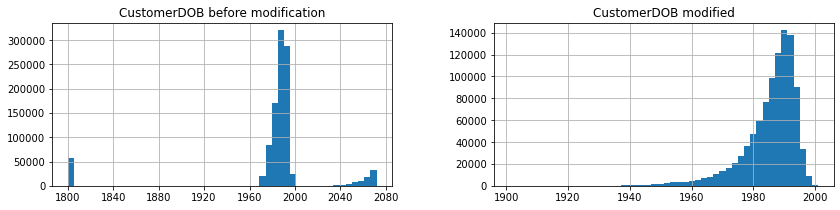

In [11]:
#Let's create our plotting space
fig, ax = plt.subplots(1,2, figsize = (14, 3))

#Plot the original data
hist = data_cop.hist(column='CustomerDOB', bins = 50, ax = ax[0])
ax[0].set_title('CustomerDOB before modification')

#Plot the data after our modification
hist2 = data.hist(column='CustomerDOB', bins = 50, ax = ax[1])
ax[1].set_title('CustomerDOB modified')

### Number of transaction per CustomerID

In [22]:
# Number of transactions per CustomerID = nr_trans
nr_trans = data[['CustomerID','TransactionID']].groupby(by = 'CustomerID').count()
nr_trans.rename(columns = {'TransactionID' : 'nr_trans'}, inplace = True)

### Number of transaction that have a value larger than 100

In [23]:
# Number of transaction with an ammount greater than 100 = nr_trans_greater_100
nr_trans_greater_100 = data[['CustomerID','TransactionAmount_INR']].query("TransactionAmount_INR > 100").groupby(by= "CustomerID").count()
nr_trans_greater_100.rename(columns = {'TransactionAmount_INR' : 'trans_greater_100'}, inplace = True)

### Mean of transactions for each customer

In [14]:
# The mean of the transactions done by each CustomerID = mean_trans
mean_trans = data[['CustomerID','TransactionAmount_INR']].groupby(by='CustomerID').mean()
mean_trans.rename(columns = {'TransactionAmount_INR':'mean_trans' }, inplace = True)

### Mean of total Balance for each customerID

In [15]:
# The mean of the Account Balance done by each CustomerID = mean_balance
mean_balance = data[['CustomerID','CustAccountBalance']].groupby(by='CustomerID').mean()
mean_balance.rename(columns = {'CustAccountBalance':'mean_balance' }, inplace = True)

### Mean difference between the mean balance and the mean transaction

In [16]:
#mean_diff. Aka Utilization
mean_diff = pd.DataFrame( mean_balance.mean_balance.sub(mean_trans.mean_trans, axis = 0) )
mean_diff.columns = ['mean_diff']

### Most frequent gender for each customerID

In [17]:
gender_most_freq = data.groupby(by = 'CustomerID').apply(lambda x: x['CustGender'].value_counts().index[0])
gender_most_freq = pd.DataFrame(gender_most_freq)
gender_most_freq.columns = ['gender_most_freq']
# converting 'M' to 1 and 'F' to 0
gender_most_freq['gender_most_freq'] = gender_most_freq['gender_most_freq'].apply(lambda x: 1 if x=='M' else 0)

### Most frequent location 

In [18]:
# most_freq_loc new
most_freq_loc = data.groupby(by='CustomerID').apply(lambda x: x['CustLocation'].value_counts().index[0])
most_freq_loc = pd.DataFrame(most_freq_loc)
most_freq_loc.columns = [ 'most_freq_loc']

### Merge all the 7 features into one df

In [24]:
# merging nr_trans and nr_trans_greater_100 separately to ensure correct format
nr_trans_and_nr_greater_100 = nr_trans.merge(nr_trans_greater_100, on= 'CustomerID', how='left').fillna(0)
# all the dfs to be concatenated
dfs = [nr_trans_and_nr_greater_100, mean_trans, mean_balance, mean_diff, gender_most_freq, most_freq_loc]

df_7 = pd.concat(dfs, 1)

/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_41930/3440457736.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_7 = pd.concat(dfs, 1)


We store the dataframe in a csv file named 'seven_params_3.csv' for later usage.

In [26]:
# saving for later usage
# TODO: delete before final commit
df_7.to_csv('seven_params_3.csv', sep=',', encoding='utf-8', index = False)

### 20 Features

### 1st and 2nd features: <br>
The minimum and maximum number of Transactions done by each CustomerID

In [22]:
def findMinMaxTrans(data) -> pd.DataFrame:
    #first we group by CustomerID
    #then we compute both the minimum and maximum with the function ".agg"
    return data.groupby("CustomerID").agg(  min_trans = ("TransactionAmount_INR", min),
                                            max_trans = ("TransactionAmount_INR", max),
                                            )

### 3rd and 4th features: <br>
This is the function used to calculate the 0.25 quantile and the 0.75 quantile of the TransactionAmount for each CustomerID

In [36]:
def findQuant(data, quant) -> pd.DataFrame:
    #first we group by CustomerID and select only the columns that we need, then we apply the function "quantile" to obtain our wanted quantile
    df = data.groupby('CustomerID')[['CustomerID','TransactionAmount_INR']].quantile(quant)
    
    #Rename the colum and return the dataframe
    return df.rename(columns = {'TransactionAmount_INR':f'{quant}_quant_trans' })

### 5th feature: <br>
The number of unique transactions(unique ammount) for each customerID

In [47]:
def findTransValueVar(data) -> pd.DataFrame:
    #First we groupby CustomerID
    #Then we compute (the count of the unique values/ the number of transactions)
    var =  data.groupby('CustomerID').apply(lambda group: group['TransactionAmount_INR'].nunique()/len(group['TransactionAmount_INR']))
    
    #Rename the column and return the dataframe
    return pd.DataFrame(var).rename(columns={'TransactionAmount_INR':'trans_val_var'})

### 6th Feature: <br>
The minimum and maximum number of Account Balance of each CustomerID

In [53]:
def findMinMaxDiffBalance(data) -> pd.DataFrame:
    #We group by CustomerID
    #Then we compute the min and max balance for each customer
    df =  data.groupby("CustomerID").agg(  min_balance = ("CustAccountBalance", min),
                                            max_balance = ("CustAccountBalance", max),
                                            )

    #Return the difference between the min and max balance
    df['diff_balance'] =  df.max_balance.sub(df.min_balance, axis = 0)
    return df

### 7th, 8th, 9th, 10th Feature.

The mean time of transactions for each CustomerID <br>
The maximum hour of each transaction for each CustomerID <br>
The minimum hour of each transaction for each CustomerID <br>
The most frequent time at which the CustomerID has the most transactions <br>

In [80]:

def findTransactionTimes(data) -> pd.DataFrame:
    hours_data = data[['CustomerID', 'TransactionTime']]
    hours_data['TransactionTime'] = pd.to_datetime((hours_data['TransactionTime']).astype(str)).dt.hour
    mean_hour = hours_data.groupby(by = 'CustomerID').mean()
    max_hour = hours_data.groupby(by = 'CustomerID').max()
    min_hour = hours_data.groupby(by = 'CustomerID').min()
    most_freq_hour = hours_data.groupby(by = 'CustomerID')['TransactionTime'].apply(lambda x: x.value_counts().index[0])
    most_freq_hour = pd.DataFrame(most_freq_hour)

    df = pd.concat([mean_hour, max_hour, min_hour, most_freq_hour], 1)
    df.columns = ['mean_hour', 'max_hour', 'min_hour', 'most_freq_hour']

    return df

### 11th, 12th, 13th feature

The Most frequent day of the week <br>
The Most frequent day of the Months <br>
The Number of different month <br>


In [165]:
def findTransactionDate(data) -> pd.DataFrame:
    dates = data[['CustomerID', 'TransactionDate']]
    #dates['dt'] = pd.to_datetime(dates.TransactionDate.astype(str))
    most_freq_weekday = dates.groupby(by = 'CustomerID').apply(lambda group: group.TransactionDate.dt.weekday.value_counts().index[0])
    most_freq_month = dates.groupby(by = 'CustomerID').apply(lambda group: group.TransactionDate.dt.month.value_counts().index[0])
    nr_diff_months = dates.groupby(by = 'CustomerID').apply(lambda group: group.TransactionDate.dt.month.nunique())

    frame = {'most_freq_weekday': most_freq_weekday, 'most_freq_month': most_freq_month, 'nr_diff_months': nr_diff_months}
    df = pd.DataFrame(frame)
    return df

### 14th feature

Number of unique locations for each CustomerID


In [112]:
def findNrLocs(data) -> pd.DataFrame:
    df =  pd.DataFrame(data.groupby(by = 'CustomerID')['CustLocation'].nunique())
    df.columns = ['nr_diff_locs']
    return df

### 15th feature

Number of unique date of birth for each CustomerDOB

In [113]:
def findNrDOB(data) -> pd.DataFrame:
    df = pd.DataFrame(data.groupby(by = 'CustomerID')['CustomerDOB'].nunique())
    df.columns = ['nr_diff_dob']
    return df

### 16th feature

The mean age for each CustomerID


In [206]:
def findMeanAge(data):
    df = data[['CustomerID', 'TransactionDate', 'CustomerDOB']].groupby(by = 'CustomerID').apply(lambda group: (group.TransactionDate-group.CustomerDOB ).astype('timedelta64[Y]').mean() )# might have to select in data already
    df = pd.DataFrame(df)
    df.columns = ['mean_age_trans']
    return df

### 17th feature

The number of transaction greater than 1000

In [171]:
def findNrTrans1K(data) -> pd.DataFrame:
    df = data[['CustomerID','TransactionAmount_INR']].query("TransactionAmount_INR > 10000").groupby(by= "CustomerID").count()
    df.columns = ['trans_greater_1k']
    return df

### 18th feature

The number of times the CustomerID has more than 100 in their back account balance

In [141]:
def findNrBalance100K(data) -> pd.DataFrame:
    df = data[['CustomerID','CustAccountBalance']].query("CustAccountBalance > 100").groupby(by= "CustomerID").count()
    df.columns = ['balance_greater_100k']
    return df

### 19th and 20th feature

The mean ratio between the transaction ammount and the account balance <br>
The max ratio between the transaction ammount and the account balance

In [198]:
def findTrans_ValBalRatio(data) -> pd.DataFrame:
    mean_ratio = data.groupby(by = 'CustomerID').apply(lambda group: (group.TransactionAmount_INR / group.CustAccountBalance).mean())
    max_ratio = data.groupby(by = 'CustomerID').apply(lambda group: (group.TransactionAmount_INR / group.CustAccountBalance).min())
    frame = {'mean_ratio': mean_ratio, 'max_ratio': max_ratio}
    df = pd.DataFrame(frame)
    return df

### Merge all feature

The function "features_20" will return a new dataframe with all the previosly selected features.

In [207]:
def features_20(data): 
    
    #min and max of transaction for each customerID
    min_max_trans = findMinMaxTrans(data)
    #quantiles of transactions for each customerID
    quant_75_trans = findQuant(data, 0.75)
    quant_25_trans = findQuant(data, 0.25)
    # ratio of unique transactions amounts for customerID
    trans_val_var = findTransValueVar(data)
    
    #min and max of balance for each customerID
    min_max_diff_balance = findMinMaxDiffBalance(data)
    
    # get max_hour, min_hour, mean_hour and most frequent hour of transactions for customerID
    transaction_times = findTransactionTimes(data)
    
    # get most frequent weekdy, most frequent month, and number of differnt months for transactions done by the customerID
    transaction_dates = findTransactionDate(data)
    
    # number of different locations from which a customerID has made transactions
    nr_diff_locs = findNrLocs(data)
    
    # nr of unique dates of birth for customerID, might roughly be the number of people using the account
    nr_diff_dob = findNrDOB(data) 
    
    # mean age of customerID at times of transaction (in years)
    age_mean = findMeanAge(data)
    
    # number transactions that exceed 1000 INR
    nr_trans_1k = findNrTrans1K(data) # dimension!
    
    # number transaction instances at which the customer balance was > 100000
    nr_balance_100k = findNrBalance100K(data)
    
    # transaction amount/balance ratio , return the mean and max of this ratio
    trans_valbalratio = findTrans_ValBalRatio(data)

    # merging dataframes with different dimensionality separately
    pre_df = min_max_trans.merge(nr_trans_1k, on = 'CustomerID', how = 'left').fillna(0)
    pre_df = pre_df.merge(nr_balance_100k, on = 'CustomerID', how = 'left').fillna(0)

    df_all = pd.concat([pre_df, quant_75_trans, quant_25_trans, trans_val_var, min_max_diff_balance, transaction_times, transaction_dates, 
                        nr_diff_locs, nr_diff_dob, age_mean, trans_valbalratio], 1)
    
    return df_all    

    # these were originally included:
    #avg_nr_trans_perday = group.groupby(by= 'TransactionDate').count().mean()
    #first_freq_loc = group['CustLocation'].agg(lambda x:x.value_counts().index[0])
    #std_balance = group['CustAccountBalance'].std()
    

In [173]:
# calling the function features_20() for the data 'bank_transactions.csv'
data_20 = features_20(data)

/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_3943/457625945.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df = data.groupby('CustomerID')[['CustomerID','TransactionAmount_INR']].quantile(quant)
/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_3943/457625945.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df = data.groupby('CustomerID')[['CustomerID','TransactionAmount_INR']].quantile(quant)
/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_3943/1643579581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [26]:
data_20.head()

,CustomerID,min_trans,max_trans,trans_greater_1k,balance_greater_100k,0.75_quant_trans,0.25_quant_trans,trans_val_var,min_balance,max_balance,...,min_hour,most_freq_hour,most_freq_weekday,most_freq_month,nr_diff_months,nr_diff_locs,nr_diff_dob,mean_age_trans,mean_ratio,max_ratio
0,C1010011,356.0,4750.0,2.0,2.0,3651.50,1454.50,1.0,32500.73,120180.54,...,1,12,0,9,1,2,2,28.0,0.074556,0.002962
1,C1010012,1499.0,1499.0,1.0,1.0,1499.00,1499.00,1.0,24204.49,24204.49,...,20,20,6,8,1,1,1,22.0,0.061931,0.061931
2,C1010014,250.0,1205.0,2.0,2.0,966.25,488.75,1.0,38377.14,161848.76,...,15,15,4,1,2,1,2,27.0,0.016472,0.001545
3,C1010018,30.0,30.0,0.0,1.0,30.00,30.00,1.0,496.18,496.18,...,17,17,3,9,1,1,1,26.0,0.060462,0.060462
4,C1010024,5000.0,5000.0,1.0,1.0,5000.00,5000.00,1.0,87058.65,87058.65,...,14,14,3,8,1,1,1,51.0,0.057433,0.057433


We store the output in a csv file named 'twenty_params_2.csv' for later usage

In [203]:
#TODO delete this for final commit
# storing for later usage
data_20.to_csv('twenty_params_2.csv', sep = ',', encoding = 'utf-8')

## 2.2 Choose your features (variables)!

#### loading the data and packages

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from datetime import datetime as dt


import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import normalize

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.sparse import csr_matrix


In [2]:
# loading dataframes and concatenating
# data_20 = pd.read_csv('twenty_params_2.csv', delimiter = ',') 
# data_7 = pd.read_csv('seven_params_3.csv', delimiter = ',').reset_index(drop=True)

In [3]:
data_27 = pd.concat([data_20, data_7], axis = 1) # forming one dataframe of 27 features
data_27.set_index('CustomerID', inplace = True)

In [4]:
data_27.fillna(0, inplace = True) # fill NA cells with 0
data_27.replace([np.inf, -np.inf], 0, inplace=True) # replace inf values with 0

In [5]:
cols_for_norm = data_27.columns[0:28] # for now selecting column names with numerical values
data_num = data_27[cols_for_norm] # forming new dataframe with only numerical parameters
data_num.head()

,min_trans,max_trans,trans_greater_1k,balance_greater_100k,0.75_quant_trans,0.25_quant_trans,trans_val_var,min_balance,max_balance,diff_balance,...,nr_diff_dob,mean_age_trans,mean_ratio,max_ratio,nr_trans,trans_greater_100,mean_trans,mean_balance,mean_diff,gender_most_freq
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,356.0,4750.0,2.0,2.0,3651.50,1454.50,1.0,32500.73,120180.54,87679.81,...,2,28.0,0.074556,0.002962,2,2.0,2553.0,76340.635,73787.635,0
C1010012,1499.0,1499.0,1.0,1.0,1499.00,1499.00,1.0,24204.49,24204.49,0.00,...,1,22.0,0.061931,0.061931,1,1.0,1499.0,24204.490,22705.490,1
C1010014,250.0,1205.0,2.0,2.0,966.25,488.75,1.0,38377.14,161848.76,123471.62,...,2,27.0,0.016472,0.001545,2,2.0,727.5,100112.950,99385.450,0
C1010018,30.0,30.0,0.0,1.0,30.00,30.00,1.0,496.18,496.18,0.00,...,1,26.0,0.060462,0.060462,1,0.0,30.0,496.180,466.180,0
C1010024,5000.0,5000.0,1.0,1.0,5000.00,5000.00,1.0,87058.65,87058.65,0.00,...,1,51.0,0.057433,0.057433,1,1.0,5000.0,87058.650,82058.650,1


## 2.2 Choose your features (variables)!

### Data Normalization
The initial data contains both continuous and discrete features which implies that the features variances may be of very different scales. We conduct a dimensionality reduction by PCA and want to obtain dimensions that retain information from both feature types.<br />
If this step is not conducted a PCA to a single dimension will already retain 80% of variance. <br />
<br />
To illustrate we plot below the PCA of unnormalized data projected into the space of the first two principal components (3 in total). <br />
Clustering with k = 5 is conducted and the centroids shown as 'x'

Text(0.5, 1.0, 'k = 5 for unnormalized data')

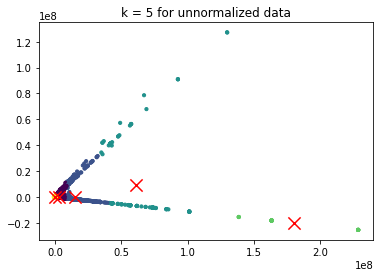

In [8]:
# by setting n_components to float in [0,1] sklearn estimates the nr of dimensions to keep
pca = PCA(n_components=3)

pca_data_notnorm = pca.fit_transform(data_num) # storing unnormalized data transformed with pca

kmeans = KMeans(n_clusters=5, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, copy_x=True, algorithm='auto')

kmeans.fit(pca_data_notnorm)  # fit unnormalized data

#plot the kmeans 
plt.scatter(pca_data_notnorm[:, 0], pca_data_notnorm[:, 1], s=10, c = kmeans.labels_.astype(float))

centroids = kmeans.cluster_centers_ 
plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red') # scatterplot of first two principal components
plt.title('k = 5 for unnormalized data')

Using sklearn.preprocessing functions, we preprocess the data. We show two different approaches since the high dimensionality of our data leads to little separation possibility between customers. 

In [6]:
# import ScalerClasses from sklearn.preprocessing
stdScaler = StandardScaler()
fctScaler = FunctionTransformer(np.log1p)
powerScaler = PowerTransformer()

### 1. Approach
In a first approach we the data parameters were scaled with different scalers implemented in sklearn. In a trial and error approach the goal was to obtain some separation of data points over the space of the first two principal components, guided by the standard deviations of the parameters. <br />
We try to reduce the variability of features that we term less indicatory, for example min_ratio (min ratio of transaction amount to account balance ) whereas we would want to set larger focus on the age of the bank account users.

In [9]:
cols_for_std_scaling = [ 'max_ratio','min_trans', 'max_trans', 'trans_greater_100', 'diff_balance', 'mean_age_trans']
cols_for_fct_scaling = [ 'mean_trans', 'mean_balance',  '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']
cols_for_pow_scaling = ['mean_ratio','mean_diff',]
cols_for_norm = [ 'max_ratio','mean_ratio', 'min_trans','mean_diff', 'diff_balance', 'mean_age_trans', 'min_balance', ]

In [11]:
data_norm = data_num.copy() # copy of numerical dataframe
# apply scalers to selection of columns of copy of the numerical dataframe
data_norm[cols_for_std_scaling] = stdScaler.fit_transform(data_norm[cols_for_std_scaling])
data_norm[cols_for_fct_scaling] = fctScaler.transform(data_norm[cols_for_fct_scaling])
data_norm[cols_for_pow_scaling] = powerScaler.fit_transform(data_norm[cols_for_pow_scaling])
data_norm[cols_for_norm] = normalize(data_norm[cols_for_norm])

In [12]:
data_norm.head()

,min_trans,max_trans,trans_greater_1k,balance_greater_100k,0.75_quant_trans,0.25_quant_trans,trans_val_var,min_balance,max_balance,diff_balance,...,nr_diff_dob,mean_age_trans,mean_ratio,max_ratio,nr_trans,trans_greater_100,mean_trans,mean_balance,mean_diff,gender_most_freq
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,-0.015200,0.469705,2.0,2.0,8.203167,7.283105,1.0,0.999255,11.696759,0.012369,...,2,-0.029781,-0.014714,-0.000744,2,1.906793,7.845416,11.242974,0.001134,0
C1010012,0.003568,-0.020811,1.0,1.0,7.313220,7.313220,1.0,0.994686,10.094335,-0.006337,...,1,-0.099152,-0.023833,-0.000761,1,0.102428,7.313220,10.094335,-0.012126,1
C1010014,-0.016632,-0.065171,2.0,2.0,6.874457,6.193895,1.0,0.997237,11.994424,0.019590,...,2,-0.040222,-0.056508,-0.000730,2,1.906793,6.590988,11.514064,0.006837,0
C1010018,-0.034177,-0.242457,0.0,1.0,3.433987,3.433987,1.0,0.994246,6.208952,-0.010298,...,1,-0.086763,-0.040427,-0.001236,1,-1.701937,3.433987,6.208952,-0.032212,0
C1010024,0.054237,0.507426,1.0,1.0,8.517393,8.517393,1.0,0.977403,11.374349,-0.005526,...,1,0.202848,-0.023589,-0.000664,1,0.102428,8.517393,11.374349,0.002725,1


For the normalized data we conduct the same illustration as for the unnormalized data: <br />
Do a principal component analysis with n_components = 3 and cluster the data with k = 5 centroids.

Text(0.5, 1.0, 'k = 5 for normalized data')

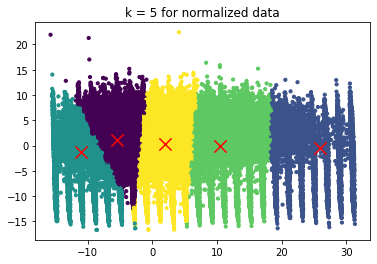

In [13]:
pca = PCA(n_components=3) # by setting n_components to float in [0,1] sklearn estimates the nr of dimension to keep
pca_data = pca.fit_transform(data_norm) # fitting and transforming the normalized data

kmeans = KMeans(n_clusters=5, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, copy_x=True, algorithm='auto')
kmeans.fit(pca_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], s=10, c = kmeans.labels_.astype(float)) # plotting the first two principal components

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red') # plotting centroids
plt.title('k = 5 for normalized data')

### 2. Approach
In a second approach we preselect the features we want to focus on. After plotting a heatmap and distinguishing features with very high correlation, we select only one parameter out of a set of parameters with correlation larger than 0.80. <br /> <br />
By following this approach we drop features that, for most customers, contain the same information. For example if a customer only conducts one transaction, the mean, max, min etc. transaction values would all be the same. <br /> <br />
We reduce the data to 12 parameters that we scale with the sklearn functions.

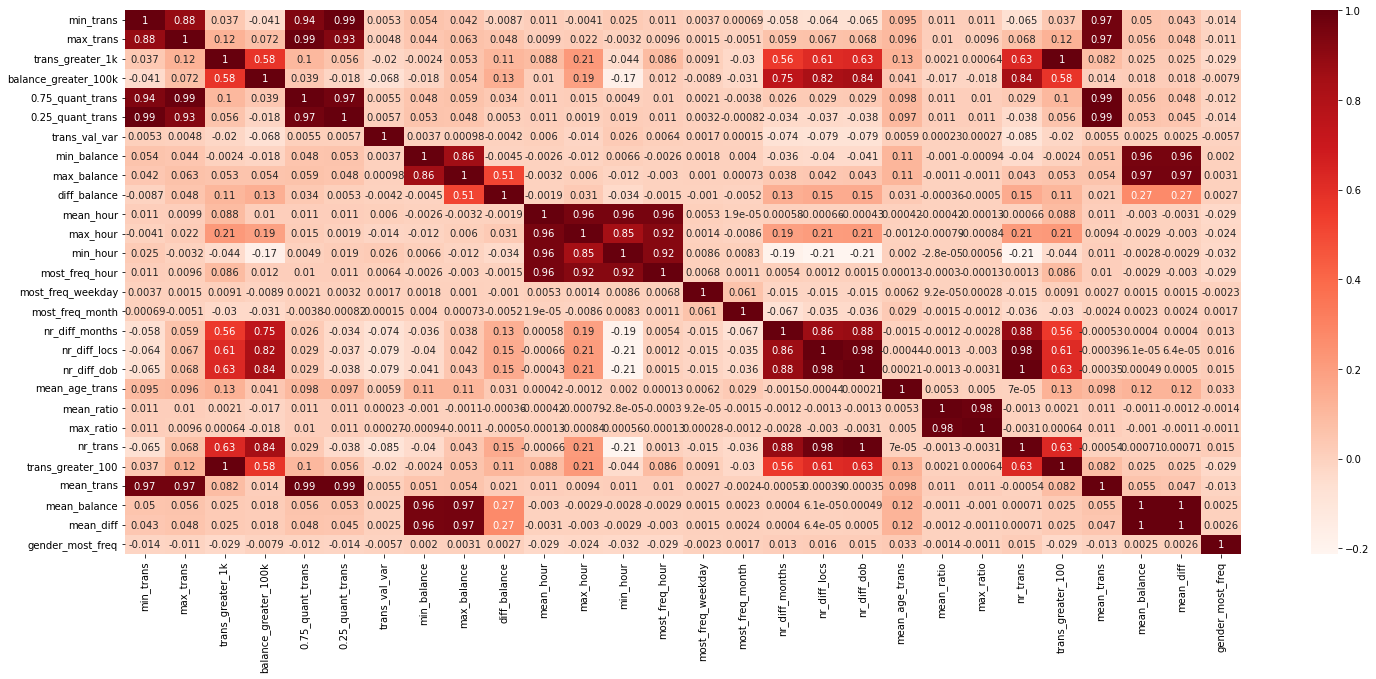

In [14]:
import seaborn as sns # plotting library

plt.figure(figsize=(25,10))
cor = data_num.corr() # calculate correlation for parameters
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds) # plot a heat map
plt.show()

In [7]:
#selecting columns to include in reduced set of parameters 
cols_data_num_sel = ['mean_trans', 'balance_greater_100k','trans_val_var', 'most_freq_hour', 'most_freq_weekday', 'most_freq_month', 'nr_diff_dob', 'mean_age_trans', 'mean_ratio', 'nr_trans', 'mean_balance', 'gender_most_freq']
data_num_sel = data_num[cols_data_num_sel]

In [8]:
# selecting columns for scaling
cols_for_std_scaling = [ 'mean_age_trans', 'nr_trans', 'nr_diff_dob']
cols_for_norm = [ 'mean_trans', 'balance_greater_100k','trans_val_var', 'mean_age_trans', 'mean_ratio', 'mean_balance' ]

In [9]:
data_norm = data_num_sel.copy() # creating a new dataframe data_norm, to be updated with scaled values 

data_norm[cols_for_std_scaling] = stdScaler.fit_transform(data_norm[cols_for_std_scaling])
data_norm[cols_for_norm] = normalize(data_norm[cols_for_norm])

In [10]:
data_norm.head()

,mean_trans,balance_greater_100k,trans_val_var,most_freq_hour,most_freq_weekday,most_freq_month,nr_diff_dob,mean_age_trans,mean_ratio,nr_trans,mean_balance,gender_most_freq
CustomerID,,,,,,,,,,,,
C1010011,0.033424,0.000026,0.000013,12,0,9,1.910661,-0.000004,9.760821e-07,1.897629,0.999441,0
C1010012,0.061812,0.000041,0.000041,20,6,8,-0.399228,-0.000041,2.553751e-06,-0.400541,0.998088,1
C1010014,0.007267,0.000020,0.000010,15,4,1,1.910661,-0.000004,1.645276e-07,1.897629,0.999974,0
C1010018,0.060351,0.002012,0.002012,17,3,9,-0.399228,-0.001090,1.216321e-04,-0.400541,0.998173,0
C1010024,0.057338,0.000011,0.000011,14,3,8,-0.399228,0.000027,6.586142e-07,-0.400541,0.998355,1


Transforming the data by a PCA with n_components set to 3 and doing kmeans clustering with n_clusters = 5, we obtain data points with larger distances. We use this normalized data for further analysis in the following parts.

Text(0.5, 1.0, 'k = 5 for normalized data')

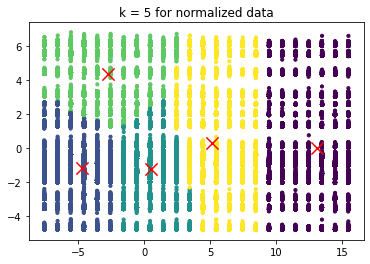

In [18]:
pca = PCA(n_components=3) # pca with 3 components
pca_data = pca.fit_transform(data_norm) # fitting selection of scaled columns

kmeans = KMeans(n_clusters=5, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, copy_x=True, algorithm='auto')
kmeans.fit(pca_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], s=10, c = kmeans.labels_.astype(float))

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('k = 5 for normalized data')

### Dimensionality Reduction
The dimensionality is reduced using sklearns PCA method. The number of dimensions is chosen such that > 85 % of the total data variance is retained.

In [11]:
pca = PCA(n_components=0.85) # by setting n_components to float in [0,1] sklearn estimates the nr of dimension to keep
pca_data = pca.fit_transform(data_norm) # back to data_num from data_norm because kmeans says 0 vectors, no! my fault
print(pca_data.shape) # checking what the dimension of the reduced data is

sparse_pca_data = csr_matrix(pca_data) # delete ?

(839081, 3)


The dataset is reduced to 3 dimensions, which makes computation much more feasible. <br />
<br />
The features variances define how strongly they're represented in the pca output, resulting for a weighting by difference.<br />
<br />
There is always some risk of loosing valuable information when focusing only on the parameters of high variance. Additionally the variance of our data will strongly depend on the normalization previously conducted on it, a factor by which we bias the output. <br />
<br />
By introducing a new set of dimensions, the datas space can no longer be interpreted to correspond with the original data parameters.

In [21]:
r = np.abs(pca.components_) # weighting of original data in constructing the new dimensions
r/r.sum(axis=0) # normalizing so get percentage of contribution for each component

array([[5.53358334e-01, 4.98294776e-01, 5.96046933e-01, 9.95893254e-01,
        2.82950818e-03, 7.38706637e-04, 1.02896769e-02, 5.76629248e-01,
        4.61405202e-01, 9.06590802e-03, 1.06671157e-01, 7.58758809e-01],
       [8.63464422e-02, 3.68963078e-02, 1.05126170e-01, 1.11071749e-03,
        9.34709706e-02, 9.05216251e-01, 6.35437906e-01, 2.53048862e-01,
        1.13801441e-01, 6.36473301e-01, 4.11321293e-01, 6.87395592e-02],
       [3.60295224e-01, 4.64808916e-01, 2.98826896e-01, 2.99602893e-03,
        9.03699521e-01, 9.40450424e-02, 3.54272417e-01, 1.70321890e-01,
        4.24793356e-01, 3.54460791e-01, 4.82007550e-01, 1.72501631e-01]])

We see that the first principal component is mainly built from the fourth column of our normalized data, which corresponds to most frequent hour. Second strongest weighting comes from the customers gender. These are both categorical data features which might bias their weighting here.

We test how the explained variance relates to the number of principal components. Below we plot the total explained variance retained in the reduced data versus n_components.

Visibly practically all variance can be reduced to 4 components.

In [33]:
explained_var = [] # list of explained variance for n_components = i
for i in range(2,10):
    pca_c = PCA(n_components = i) # create PCA with number components corresponding to loop iteration
    pca_c.fit_transform(data_norm) # transform normalized data 
    pca_v = pca_c.explained_variance_ratio_.cumsum()[-1] # variance of data explained by the new dimensions
    explained_var.append(pca_v)

Text(0, 0.5, 'total explained variance')

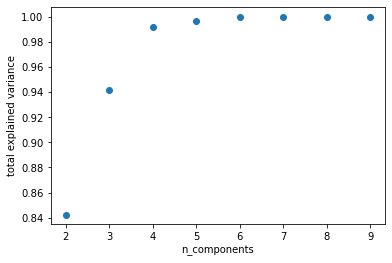

In [34]:
plt.scatter(np.arange(2,10), explained_var)
plt.xlabel('n_components')
plt.ylabel('total explained variance')

## 2.3 Clustering!

In [35]:
'''
the clustering algorithm is based on the kmeans approach
main function:
    kmeans()           takes number of clustercenters, data, max iterations
                       sets global variables, calls mapping and reducing functions in a while loop
                       while loop is terminated if convergence of max iterations are passed

two subfunctions are called by the main function:
    findNearCentroid() which takes a row index and compares it to the 
                       centroids stored for the current iteration. It then returns
                       a tuple of (cluster_index it is closest to, the row index)
    makeNewCentroids() takes a list of tuples(cluster_index, row_index)
                       shuffles the tuples to create a dictionary of {cluster_index : list(row_indices assigned to cluster)}
                       then takes the data of clustered rows to construct new cluster centers
'''

def findNearCentroid(row): # mapping function: each data row to cluster center
    dist = np.sum((centroids_hist[iter]-data[row])**2, axis=1) # calculate distance between cluster centers and data row
    closest = np.argmin(dist) # pick index of lowest index = assigned cluster
    return(closest,row) # return (index of closest cluster, row)


def makeNewCentroids(assigned): #shuffle and reduce by calculating new centroids from data
    shuffled = {} # dictionary of cluster : list(rows of data assigned to cluster)
    
    for e in assigned: # filling shuffled with tuples from 'assigned'
        try:
            shuffled[e[0]].append(e[1])
        except:
            shuffled[e[0]] = [e[1]]

    centroids = map( lambda rows: np.mean(data[rows], axis = 0), shuffled.values()) # for each centroid calculate the mean of the rows assigned to it
    new_centroids = np.array(list(centroids)) # format to np array
    return (shuffled, new_centroids) # shuffled needed for final iteration and colormapping of row data

    

def kmeans(k, data, maxIter): # number of centroids, data, max number of iterations
    centroids = np.random.randint(0, data.shape[0], k) # get k random indices
    
    global centroids_hist # np matrix that stores the history of centroids
    centroids_hist = np.zeros((maxIter+1, k, data.shape[1]), dtype=float)
    centroids_hist[0]= data[centroids] # set the initial centroids as the data of the rows with index = randint

    rows = np.arange(0, data.shape[0]) # np array of row indices

    global iter # iterations that have passed
    iter = 0

    converge = False # boolean indicating if algorithm has converged

    while tqdm(iter < maxIter and not converge):
        centroids = centroids_hist[iter] # set centroids to centroids_hist of this iteration
        assigned = map(findNearCentroid, rows) # map rows to nearest centroid

        shuffled, new_centroids = makeNewCentroids(assigned) # shuffling and reducing
        centroids_hist[iter+1] = new_centroids # add the new centroids for the following iterations 

        if iter > 0 and np.array_equal(centroids_hist[iter],centroids_hist[iter+1]): # if max iterations passed or convergence
             converge = True # set convergence True, will exit while loop
             
        iter +=1

    return centroids_hist, shuffled # return the matrix of centroids_hist and the last assignement of centroids: list(data_rows)


### Optimal Number of Clusters 
We run the clustering algorithm with n_clusters set in the range [1,10]

#### Elbow Method
Plotting the sum of square distances of data to closest centroid versus the number of centroids.

In [36]:
var = []
for i in range(1,10):
    kmeans_t = KMeans(n_clusters=i, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, copy_x=True, algorithm='auto')
    kmeans_t.fit(sparse_pca_data)
    var.append(kmeans_t.inertia_)

Text(0.5, 1.0, 'Elbow method for ideal # clusters')

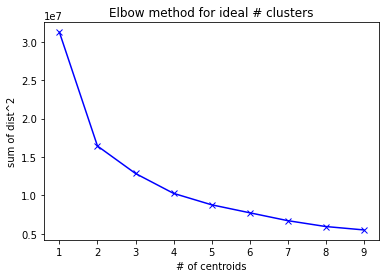

In [37]:
plt.plot(np.arange(1,10), var, 'bx-')
plt.xlabel('# of centroids')
plt.ylabel('sum of dist^2')
plt.title('Elbow method for ideal # clusters')

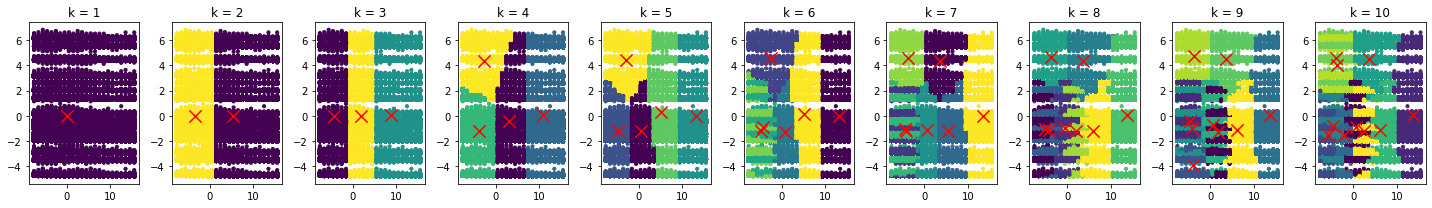

In [38]:

fig,ax = plt.subplots(1,10, figsize = (20,3))

for i in range(1,11):
    kmeans_t = KMeans(n_clusters=i, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, algorithm='auto')
    kmeans_t.fit(sparse_pca_data)

    cmap = plt.cm.get_cmap('jet', i)

    ax[i-1].scatter(pca_data[:, 0], pca_data[:, 1], s=10, c = kmeans_t.labels_.astype(float))

    centroids = kmeans_t.cluster_centers_
    ax[i-1].scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
    ax[i-1].set_title('k = '+str(i))

fig.tight_layout()

The elbow method indicates that the ideal number of clusters is around 2, with a stretch one might consider 3.
Given the above plot we can not clearly state the ideal number of clusters, there's some more interesting splitting when moving from k=6 to k=7. <br />

### Run the Algorithm
We run our algorithm with k=2 and 25 iterations. The data has shape (839081, 3) and one iteration takes around 10 seconds.

In [39]:
%%time
data  = pca_data #
out = kmeans(2, data, 25)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

CPU times: user 2min 37s, sys: 3.28 s, total: 2min 40s
Wall time: 2min 47s


In [51]:
# for each data row (customerID) get cluster centroid, used to plot colors

d = out[1] # dictionary of clusterID : list(data rows), corresponging to shuffled in kmeans function
cols = []
for k,v in d.items(): # key, list of values
    for x in v: # x = value in list = row index
        cols.append([x,k]) # append row index, cluster index

cols = np.array(cols) # format to array
cols = cols[cols[:, 0].argsort()][:,1] # sort array by row index and then take only the second column = array of cluster indices

centroids = out[0][14] # centroids of the last iteration

Text(0.5, 1.0, 'K-means with k = 5')

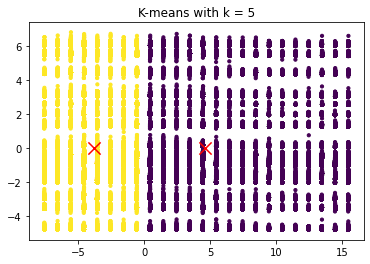

In [52]:
plt.scatter(data[:, 0], data[:, 1], s=10, c = cols)

plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('K-means with k = 5')

### KMeans with scikit-learn Library

Text(0.5, 1.0, 'K-means++ with k = 2')

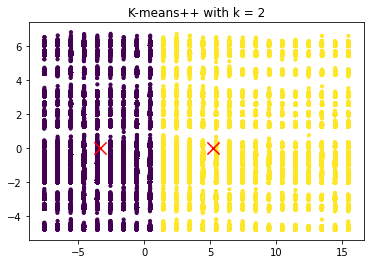

In [14]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=3, max_iter=300, tol=0.0001,random_state=None, algorithm='auto')
kmeans.fit(pca_data) # fit pca_data to scikti kmeans class object

plt.scatter(pca_data[:, 0], pca_data[:, 1], s=10, c = kmeans.labels_.astype(float)) # plot first two principal components

centroids = kmeans.cluster_centers_ 
plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red') # scatter cluster centers
plt.title('K-means++ with k = 2')

K-means++ clusters similar to our K-means algorithm. There's visibly a slight shifting of cluster centers in the 'purple cluster' but we can not assert this to a difference in the algorithms, since we only run 25 iterations on our algorithms and up to 300 with sklearns k-means++.

## 2.4 Analysing your results!

In [17]:
import math
# function takes a column of the numerical dataframe data_num
# cols is an array of cluster_indexes for each row, as returned by our kmeans algorithm

def make_bins_pv (columns, cols) -> pd.DataFrame:
    
    bins = pd.qcut(columns, 4, retbins = True, duplicates = 'drop') # put values in quartile bins
    bins = bins[1] # set bins as the array returned by pd function qcut()
    
    if len(bins)!=5: # if bins of quartiles are not unique they will be dropped, in this case do linear bins
        mn = min(columns)
        mx = math.ceil(max(columns))
        bins = np.arange(mn, mx, math.ceil((mx-mn)/4) ) # make bins using min, max values of features
        bins = np.append(bins, mx) # append max value to ensure correct format

    cut = pd.cut(x=columns, bins=bins) # categorising data into bins, returns series
    dumm = pd.get_dummies(cut) # make column out of each category
    pv = pd.pivot_table(dumm, index = cols) # build pivot table
    pv.index.name = 'Cluster'

    return pv

### Pivot Tables
Constucting Pivot Tables from normalized columns and custer labels. We observe little segregation, but for most frequent hour.

In [55]:
col = data_num['mean_trans']
mean_trans = make_bins_pv(col, cols)
mean_trans.style.set_caption('Mean Transaction')

,"(0.0, 180.0]","(180.0, 475.0]","(475.0, 1175.73]","(1175.73, 1560034.99]"
Cluster,,,,
0,0.288438,0.243444,0.235338,0.231630
1,0.220623,0.252868,0.261144,0.265184


In [57]:
col = data_num['trans_greater_1k']
trans_greater_1k = make_bins_pv(col, cols)
trans_greater_1k.style.set_caption('Number of Transactions greater than 1K')

,"(0.0, 2.0]","(2.0, 4.0]","(4.0, 6.0]"
Cluster,,,
0,0.783966,0.009565,0.000050
1,0.846288,0.010671,0.000057


In [58]:
col = data_num['most_freq_hour']
most_freq_hour = make_bins_pv(col, cols)
most_freq_hour.style.set_caption('Most Frequent Hour of Transaction')


,"(0.0, 12.0]","(12.0, 16.0]","(16.0, 20.0]","(20.0, 23.0]"
Cluster,,,,
0,0.550514,0.411760,0.000000,0.000000
1,0.000000,0.111900,0.597366,0.290735


In [60]:

col = data_num['gender_most_freq']
dumm = pd.get_dummies(col)
pv = pd.pivot_table(dumm, index = cols)
pv.index.name = 'Cluster'
pv.style.set_caption('Most Frequent Gender')

,0,1
Cluster,,
0,0.261465,0.738535
1,0.286927,0.713073


In [61]:
col = data_num['mean_age_trans']
mean_age_trans = make_bins_pv(col, cols)
mean_age_trans.style.set_caption('Mean Age at Transaction')

,"(15.0, 25.0]","(25.0, 29.0]","(29.0, 34.0]","(34.0, 115.0]"
Cluster,,,,
0,0.291377,0.266266,0.207069,0.235182
1,0.284150,0.270986,0.216328,0.228467


### Clustering score Metrics 

In [23]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

In [24]:
calinski_harabasz_score = calinski_harabasz_score(pca_data, cols)
calinski_harabasz_score

1020249.1008498162

Calinski Harabasz Score = 1020249.1 
The ratio between intracluster disperion and intercluster dispersion.

In [25]:
davies_bouldin_score = davies_bouldin_score(pca_data, cols)
davies_bouldin_score


0.7981477454174393

Davies Bouldin Score = 0.798
The ratio of intracluster distance to intercluster distance is a value within the range (0,1).
<br />
<br />
The high scores are in accordance to what we observe when plotting the two PCs or look at the pivot tables. <br />
The customers don't cluster into distinct groups and the large number of parameters results in one blob of data, hence the distance between any pair of data points is low.<br />
The most frequent hours seems to be only parameter investigated that shows to be well separated by clustering.
<br />
<br />
We propose that better clustering would mainly require a suitable normalization of features. Clustering by bank account id with information that is person specific is not ideal. Additionally more accurate results might be obtained by using a different clustering algorithm.

# Bonus : Different sklearn Clustering Algorithms

We try to implement different clustering algorithms. Spectral Clustering, Agglomerative Clustering and Mean Shift all either make the kernel crash or took more than 20 minutes without converging. Comparing with this [comparison sheet](https://scikit-learn.org/0.23/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py) on sklearn, we choose Gaussian Mixture and Birch because of their low timescales for samples with low distance.
<br /> <br />
The output of the clustering is plotted in the first two principal components with numbers of clusters = 2

Text(0.5, 1.0, 'Gaussian Mixture k = 2')

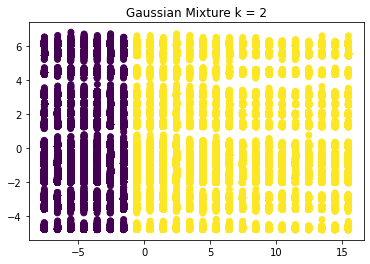

In [12]:
from sklearn.mixture import GaussianMixture

gaussian = GaussianMixture(n_components=2, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)
gaussian.fit(pca_data)

cols = gaussian.predict(pca_data)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cols)
plt.title('Gaussian Mixture k = 2')

We see very little difference in the output to kmeans++ or our kmeans implementation. However it does take nearly twice as long as kmeans++ while it is much faster than our clustering algorithm.

Text(0.5, 1.0, 'Birch k = 2')

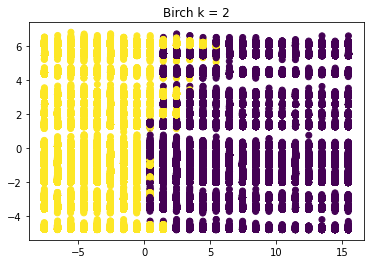

In [15]:
from sklearn.cluster import Birch

birch = Birch( threshold=0.5, branching_factor=50, n_clusters=2, compute_labels=True, copy=True)
birch.fit(pca_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=birch.labels_)
plt.title('Birch k = 2')

The output produced by Birch is slightly different from kmeans, so we check if there's better segregation of parameters by looking at the pivot tables.

In [19]:
col = data_num['most_freq_hour']
most_freq_hour = make_bins_pv(col, birch.labels_)
most_freq_hour.style.set_caption('Most Frequent Hour of Transaction')

,"(0.0, 12.0]","(12.0, 16.0]","(16.0, 20.0]","(20.0, 23.0]"
Cluster,,,,
0,0.610921,0.346323,0.000000,0.000000
1,0.008644,0.181974,0.544417,0.264965


In [20]:
col = data_num['gender_most_freq']
dumm = pd.get_dummies(col)
pv = pd.pivot_table(dumm, index = birch.labels_)
pv.index.name = 'Cluster'
pv.style.set_caption('Most Frequent Gender')

,0,1
Cluster,,
0,0.257634,0.742366
1,0.287217,0.712783


Neither mean_trans nor trans_greater_1k are significantly differently separated by Birch, compared to kmeans. The differences are only found up from the third decimals. There is some shifting in the separation of Most Frequent Hour of Transaction but it isn't clearly an improvement. There is however some improvement in the separation of Gender but only in the second decimal.
 <br /> <br />
 Given the similar performance to Kmeans but roughly six fold running time, Kmeans seems to be most applicable to our task. If given a different separation of data (which again might depend on scaling), our prefered clustering algorithm might be a different one.

# Algorithmic Question

In [62]:
# load packages
import pandas as pd
import numpy as np

In [63]:
def algo(N,M,G,sequence):

    #I create a dictionary to count the number of people that need to enter through a certain gate
    #The dictionary will be contructed in this way:
    # {"key:gate" : "value: number of people that need to enter in that gate"}
    dic = {}

    #for every number in the sequence 
    for x in sequence:

        #I check if it's value is already inside as a key
        if int(x) in dic.keys():

            #if it is, then i increase the counter
            dic[int(x)] += 1
        else:

            #Else i will instanciate it from 1
            dic[int(x)] = 1

    #This boolean will have the value "True" if 
    isEnough = True

    #list used to see when i encounter a new entrance
    list = []

    #gatekeeper that are currently stationed in a gate
    idx =  0  
    
    #iterate over the length of the sequence
    for x in range(len(sequence)):

        #If the number it's not in the list then it means that it is the first time someone goes through that gate
        if sequence[x] not in list: 
            #So i put one gatekeeper on that gate
            #increase the "idx"
            idx += 1

            #And append the number of the gate, so that i know that someone has already gone through that gate
            list.append(sequence[x])

        #Once i meet someone that has gone through that gate,
        #I decrease the overall number of people that need to go through that gate
        dic[int(sequence[x])] -= 1

        #If the value of the dictionary corrispondant to that gate is zero
        #it means that no one has to go through that gate again
        #So i can free one gatekeeper from his job
        if dic[int(sequence[x])] == 0:

            #decrease the number of gatekeeper occupied
            idx = idx - 1

        #If the number of gatekeeper occupied is greater than the number of gatekeeper that we can assign then,
        #It means that i cant cover all the gates
        if idx > G:
            #So i will change the value to "isEnough" to False
            isEnough = False

    #Print results based on "isEnough"
    print("YES") if isEnough else print("NO")


tested with input <br />
451 <br />
11333


In [65]:
#Read the input
N,M,G = map(int, input().split())
sequence = input().split()
algo(N,M,G,sequence)

YES
